# 使用 JIP

**Using the PyTorch JIT(Just-In-Time) Compiler with Pyro**

在 PyTorch 1.0 中，其首次引进了 torch.jit，它是一组编译工具，且主要目标是弥补研究与产品部署的差距。JIT 包含一种名为 Torch Script 的语言，这种语言是 Python 的子语言。使用 Torch Script 的代码可以实现非常大的优化，并且可以序列化以供在后续的 C++API 中使用。

This tutorial shows how to use the PyTorch [jit compiler](https://pytorch.org/docs/master/jit.html) in Pyro models.

> Summary:

- You can use compiled functions in Pyro models.
- You cannot use pyro primitives inside compiled functions.
- If your model has static structure, you can use a `Jit*` version of an `ELBO` algorithm, e.g.
  ```diff
  - Trace_ELBO()
  + JitTrace_ELBO()
  ```
- The [HMC](http://docs.pyro.ai/en/dev/mcmc.html#pyro.infer.mcmc.HMC) and [NUTS](http://docs.pyro.ai/en/dev/mcmc.html#pyro.infer.mcmc.NUTS) classes accept `jit_compile=True` kwarg.
- Models should input all tensors as `*args` and all non-tensors as `**kwargs`.
- Each different value of `**kwargs` triggers a separate compilation.
- Use `**kwargs` to specify all variation in structure (e.g. time series length).
- To ignore jit warnings in safe code blocks, use `with pyro.util.ignore_jit_warnings():`.
- To ignore all jit warnings in `HMC` or `NUTS`, pass `ignore_jit_warnings=True`.

Table of contents：

- [Introduction](#Introduction)
- [A simple model](#A-simple-model)
- [Varying structure](#Varying-structure)

In [1]:
import os
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro import poutine
from pyro.distributions.util import broadcast_shape
from pyro.infer import Trace_ELBO, JitTrace_ELBO, TraceEnum_ELBO, JitTraceEnum_ELBO, SVI
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.4.1')
pyro.enable_validation(True)    # <---- This is always a good idea!

## Introduction

PyTorch 使用 jit compiler 来加速模型，可以理解成 pytorch 的静态模式 like tensorflow。

PyTorch 1.0 includes a [jit compiler](https://pytorch.org/docs/master/jit.html) to speed up models. You can think of compilation as a "static mode", whereas PyTorch usually operates in "eager mode".

(Pyro 如何使用 jit) Pyro supports the jit compiler in two ways. 

- First you can use compiled functions inside Pyro models (but those functions cannot contain Pyro primitives).
- Second, you can use Pyro's jit inference algorithms to compile entire inference steps; in static models this can reduce the Python overhead of Pyro models and speed up inference.

The rest of this tutorial focuses on Pyro's jitted inference algorithms: [JitTrace_ELBO](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.trace_elbo.JitTrace_ELBO), [JitTraceGraph_ELBO](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.tracegraph_elbo.JitTraceGraph_ELBO), [JitTraceEnum_ELBO](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.traceenum_elbo.JitTraceEnum_ELBO), [JitMeanField_ELBO](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.trace_mean_field_elbo.JitTraceMeanField_ELBO), [HMC(jit_compile=True)](http://docs.pyro.ai/en/dev/mcmc.html#pyro.infer.mcmc.HMC), and [NUTS(jit_compile=True)](http://docs.pyro.ai/en/dev/mcmc.html#pyro.infer.mcmc.NUTS). For further reading, see the [examples/](https://github.com/uber/pyro/tree/dev/examples) directory, where most examples include a `--jit` option to run in compiled mode.

## 一个简单的模型

A simple model, 一个用 jit 提高速度的例子。

### SVI 推断方法


Let's start with a simple Gaussian model and an [autoguide](http://docs.pyro.ai/en/dev/infer.autoguide.html).

In [2]:
def model(data):
    loc = pyro.sample("loc", dist.Normal(0., 10.))
    scale = pyro.sample("scale", dist.LogNormal(0., 3.))
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Normal(loc, scale), obs=data)

guide = AutoDiagonalNormal(model)

data = dist.Normal(0.5, 2.).sample((100,))

First let's run as usual with an SVI object and `Trace_ELBO`.

In [3]:
%%time
pyro.clear_param_store()
elbo = Trace_ELBO()
svi = SVI(model, guide, Adam({'lr': 0.01}), elbo)
for i in range(2 if smoke_test else 1000):
    svi.step(data)

CPU times: user 3.48 s, sys: 31 ms, total: 3.51 s
Wall time: 3.54 s


Next to run with a jit compiled inference, we simply replace
```diff
- elbo = Trace_ELBO()
+ elbo = JitTrace_ELBO()
```
Also note that the `AutoDiagonalNormal` guide behaves a little differently on its first invocation (it runs the model to produce a prototype trace), and we don't want to record this warmup behavior when compiling. Thus we call the `guide(data)` once to initialize, then run the compiled SVI,

In [4]:
%%time
pyro.clear_param_store()

guide(data)  # Do any lazy initialization before compiling.

elbo = JitTrace_ELBO()
svi = SVI(model, guide, Adam({'lr': 0.01}), elbo)
for i in range(2 if smoke_test else 1000):
    svi.step(data)

CPU times: user 1.59 s, sys: 28.7 ms, total: 1.62 s
Wall time: 1.64 s


### NUTS 推断方法

Notice that we have a more than 2x speedup for this small model.

Let us now use the same model, but we will instead use MCMC to generate samples from the model's posterior. We will use the No-U-Turn(NUTS) sampler.

In [5]:
%%time
nuts_kernel = NUTS(model)
pyro.set_rng_seed(1)
mcmc_run = MCMC(nuts_kernel, num_samples=100).run(data)

Sample: 100%|████████████████████████████████████| 200/200 [00:02<00:00, 72.53it/s, step size=6.20e-01, acc. prob=0.961]                         

CPU times: user 2.72 s, sys: 42.4 ms, total: 2.76 s
Wall time: 2.78 s


We can compile the potential energy computation in NUTS using the `jit_compile=True` argument to the NUTS kernel. We also silence JIT warnings due to the presence of tensor constants in the model by using `ignore_jit_warnings=True`.

In [6]:
%%time
nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
pyro.set_rng_seed(1)
mcmc_run = MCMC(nuts_kernel, num_samples=100).run(data)

Sample: 100%|███████████████████████████████████| 200/200 [00:01<00:00, 129.67it/s, step size=6.20e-01, acc. prob=0.961]                         

CPU times: user 1.51 s, sys: 34.2 ms, total: 1.55 s
Wall time: 1.55 s


We notice a significant increase in sampling throughput when JIT compilation is enabled.

## 加速时间序列模型

Varying structure

Time series models often run on datasets of multiple time series with different lengths. To accomodate varying structure like this, Pyro requires models to separate all model inputs into tensors and non-tensors.$^\dagger$

- Non-tensor inputs should be passed as `**kwargs` to the model and guide. These can determine model structure, so that a model is compiled for each value of the passed `**kwargs`.
- Tensor inputs should be passed as `*args`. These must not determine model structure. However `len(args)` may determine model structure (as is used e.g. in semisupervised models).

To illustrate this with a time series model, we will pass in a sequence of observations as a tensor `arg` and the sequence length as a non-tensor `kwarg`:

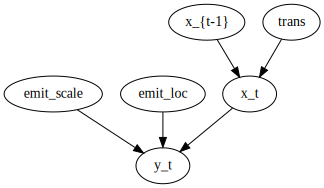

In [19]:
from graphviz import Source
Source('Digraph{x_t, emit_scale, emit_loc -> y_t; "x_{t-1}", trans -> x_t; }')

In [7]:
def model(sequence, num_sequences, length, state_dim=16):
    # This is a Gaussian HMM model.
    with pyro.plate("states", state_dim):
        trans = pyro.sample("trans", dist.Dirichlet(0.5 * torch.ones(state_dim)))
        emit_loc = pyro.sample("emit_loc", dist.Normal(0., 10.))
    emit_scale = pyro.sample("emit_scale", dist.LogNormal(0., 3.))

    # We're doing manual data subsampling, so we need to scale to actual data size.
    with poutine.scale(scale=num_sequences):
        # We'll use enumeration inference over the hidden x.
        x = 0
        for t in pyro.markov(range(length)):
            x = pyro.sample("x_{}".format(t), dist.Categorical(trans[x]),
                            infer={"enumerate": "parallel"})
            pyro.sample("y_{}".format(t), dist.Normal(emit_loc[x], emit_scale),
                        obs=sequence[t])

guide = AutoDiagonalNormal(poutine.block(model, expose=["trans", "emit_scale", "emit_loc"]))

# This is fake data of different lengths.
lengths = [24] * 50 + [48] * 20 + [72] * 5
sequences = [torch.randn(length) for length in lengths]

Now lets' run SVI as usual.

In [8]:
%%time
pyro.clear_param_store()
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, Adam({'lr': 0.01}), elbo)
for i in range(1 if smoke_test else 10):
    for sequence in sequences:
        svi.step(sequence,                                            # tensor args
                 num_sequences=len(sequences), length=len(sequence))  # non-tensor args

CPU times: user 58 s, sys: 303 ms, total: 58.3 s
Wall time: 58.3 s


Again we'll simply swap in a `Jit*` implementation
```diff
- elbo = TraceEnum_ELBO(max_plate_nesting=1)
+ elbo = JitTraceEnum_ELBO(max_plate_nesting=1)
```
Note that we are manually specifying the `max_plate_nesting` arg. Usually Pyro can figure this out automatically by running the model once on the first invocation; however to avoid this extra work when we run the compiler on the first step, we pass this in manually.

In [9]:
%%time
pyro.clear_param_store()

# Do any lazy initialization before compiling.
guide(sequences[0], num_sequences=len(sequences), length=len(sequences[0]))

elbo = JitTraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, Adam({'lr': 0.01}), elbo)
for i in range(1 if smoke_test else 10):
    for sequence in sequences:
        svi.step(sequence,                                            # tensor args
                 num_sequences=len(sequences), length=len(sequence))  # non-tensor args

CPU times: user 41 s, sys: 242 ms, total: 41.3 s
Wall time: 41.4 s


Again we see more than 2x speedup. Note that since there were three different sequence lengths, compilation was triggered three times.

$^\dagger$ Note this section is only valid for SVI, and HMC/NUTS assume fixed model arguments.